# Eye for the Blind


### Problem statement: 
In this  project, we are creating a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

In [1]:
#Import all the required libraries

import numpy as np
import os
import pandas as pd
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
import glob
from sys import getsizeof
from keras.models import Sequential
from skimage.transform import resize as imresize
from imageio import imread
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import nltk
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from keras.layers import Dropout
from IPython.display import Image
from random import randrange
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

images='./Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))
all_imgs[:10]

The total images present in the dataset: 8091


['./Images/207731022_988f6afb35.jpg',
 './Images/2077346067_0a3a5aae65.jpg',
 './Images/2078311270_f01c9eaf4c.jpg',
 './Images/2079110798_ad1370a646.jpg',
 './Images/2079152458_40712c3b40.jpg',
 './Images/207930963_af3a2f1784.jpg',
 './Images/2079554580_f18d5c181b.jpg',
 './Images/2080033499_6be742f483.jpg',
 './Images/2081141788_38fa84ce3c.jpg',
 './Images/2081446176_f97dc76951.jpg']

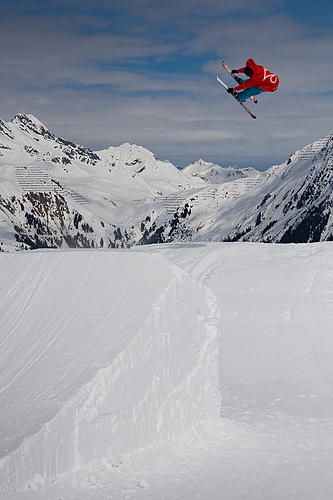

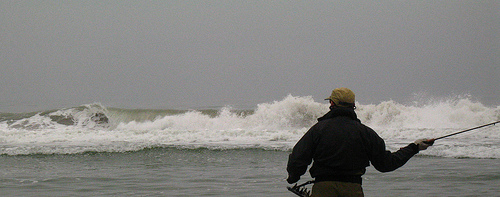

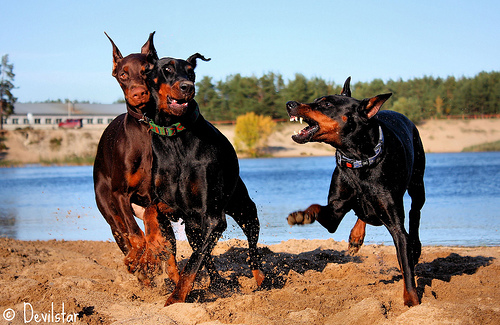

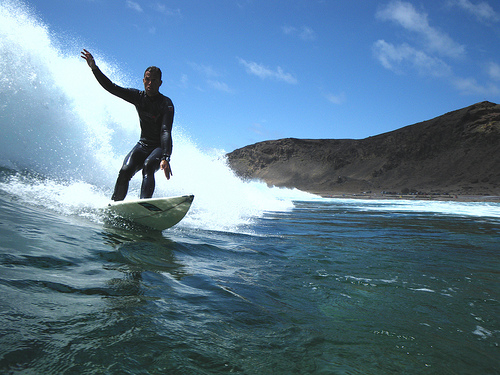

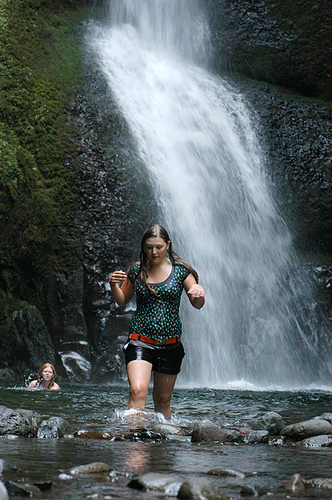

In [3]:
#Visualise both the images & text present in the dataset
from random import randrange


for i in range(5):
    indxs = randrange(0, len(all_imgs))
   
    a = Image(filename=all_imgs[indxs])
    display(a)


In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    text=pd.read_csv(filename)
    
    
    return text

doc = load_doc("captions.txt")
doc.columns=["ID","Captions"]
doc.head()

,ID,Captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:


df=doc;
df["Path"]=doc.ID.apply(lambda x: "./Images/"+x)
    
df.head()

,ID,Captions,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,./Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,./Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,./Images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,./Images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,./Images/1000268201_693b08cb0e.jpg


In [6]:
#Create a list which contains all the captions
annotations= [];
for caps in df.Captions:
     annotations.append(caps)   #write your code here


#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=df.Path.unique() #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [7]:
#Create the vocabulary & the counter for the captions
from collections import Counter

vocabulary= word_tokenize(" ".join(annotations)) #write your code here

val_count=Counter(vocabulary)


<AxesSubplot:xlabel='word'>

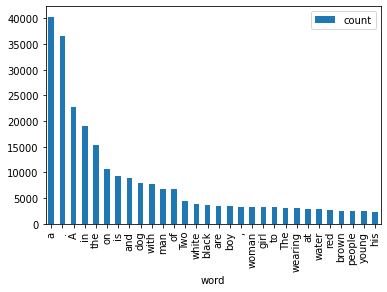

In [8]:
#Visualise the top 30 occuring words in the captions
word_df = pd.DataFrame.from_dict(val_count, orient='index').reset_index()
word_df.columns=["word","count"]
word_df.sort_values(by=["count"],ascending=False,inplace=True)
word_df[:30].plot.bar(x="word",y="count")

#write your code here

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [9]:
# create the tokenizer

annotations = df.Captions.apply(lambda s:"<start>"+" "+s+" "+"<end>")

print(annotations[:10])

topT = 5000
word_tokeniser = tf.keras.preprocessing.text.Tokenizer(num_words=topT+1,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

#word_tokeniser = Tokenizer(oov_token="<unk>")
word_tokeniser.fit_on_texts(annotations)




0    <start> A child in a pink dress is climbing up...
1    <start> A girl going into a wooden building . ...
2    <start> A little girl climbing into a wooden p...
3    <start> A little girl climbing the stairs to h...
4    <start> A little girl in a pink dress going in...
5    <start> A black dog and a spotted dog are figh...
6    <start> A black dog and a tri-colored dog play...
7    <start> A black dog and a white dog with brown...
8    <start> Two dogs of different breeds looking a...
9    <start> Two dogs on pavement moving toward eac...
Name: Captions, dtype: object


In [10]:
# Create word-to-index and index-to-word mappings.
encoded_words = word_tokeniser.texts_to_sequences(annotations)
encoded_words[:10]
#your code here

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4],
 [3, 2, 16, 10, 9, 2, 844, 10, 18, 344, 4],
 [3, 2, 16, 10, 9, 2, 1576, 236, 10, 35, 11, 138, 83, 7, 6, 152, 4],
 [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1002, 18, 641, 23, 138, 83, 5, 6, 73, 4],
 [3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4],
 [3, 14, 32, 7, 728, 806, 322, 138, 83, 4]]

In [11]:

word_tokeniser.word_index['<pad>'] = 0
word_tokeniser.index_word[0] = '<pad>'

<AxesSubplot:xlabel='word'>

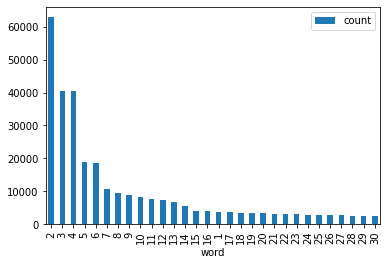

In [12]:
# Creatye a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_list=[];
for item in encoded_words:
    word_list.extend(item)


word_count=Counter(word_list);

encoded_df = pd.DataFrame.from_dict(word_count, orient='index').reset_index()
encoded_df.columns=["word","count"]
encoded_df.sort_values(by=["count"],ascending=False,inplace=True)
encoded_df[:30].plot.bar(x="word",y="count")
#your code here

In [13]:
len_list=[];
for item in encoded_words:
    len_list.append(len(item))
MAX_SEQ_LENGTH=max(len_list)
print(max(len_list))

39


In [14]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
from tensorflow.keras.preprocessing.sequence import pad_sequences

cap_vector = pad_sequences(encoded_words, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
  #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [15]:
#write your code here to create the dataset consisting of image paths
paths=df.Path

In [16]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

2023-02-07 04:33:06.330408: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-07 04:33:06.330492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


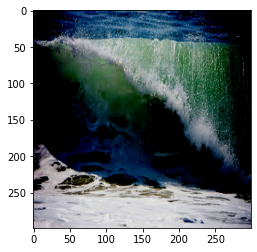

In [17]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
indxs = randrange(0, len(all_imgs))
img1,img1_path = load_image(all_imgs[indxs])
print("Shape after resize :", img1.shape)
plt.imshow(img1)



In [18]:
encode_train_set = sorted(set(all_imgs))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [19]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [21]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [23]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [24]:
from sklearn.model_selection import train_test_split

#write your code here
image_train, image_test, caption_train, caption_test = train_test_split(doc.Path,cap_vector,test_size=0.2,random_state=42)

In [25]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [27]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

from tqdm import tqdm

for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()
        
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset



100%|██████████| 253/253 [00:40<00:00,  6.17it/s]


In [28]:
train_dataset=gen_dataset(image_train,caption_train)
test_dataset=gen_dataset(image_test,caption_test)

In [29]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [30]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [31]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = Dense(embed_dim)
        self.dropout = Dropout(0.5)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [32]:
encoder=Encoder(embedding_dim)

### Attention model

In [33]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights


### Decoder

In [34]:
class Decoder(Model):
   
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units)
        self.d2 = Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) #shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [35]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [36]:
word_tokeniser.word_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'dog': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'two': 14,
 'white': 15,
 'black': 16,
 'boy': 17,
 'are': 18,
 'woman': 19,
 'girl': 20,
 'to': 21,
 'wearing': 22,
 'at': 23,
 'people': 24,
 'water': 25,
 'red': 26,
 'young': 27,
 'brown': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'dogs': 32,
 'running': 33,
 'through': 34,
 'playing': 35,
 'while': 36,
 'shirt': 37,
 'down': 38,
 'standing': 39,
 'ball': 40,
 'little': 41,
 'grass': 42,
 'snow': 43,
 'child': 44,
 'person': 45,
 'jumping': 46,
 'over': 47,
 'three': 48,
 'front': 49,
 'sitting': 50,
 'holding': 51,
 'up': 52,
 'field': 53,
 'small': 54,
 'by': 55,
 'large': 56,
 'green': 57,
 'one': 58,
 'group': 59,
 'yellow': 60,
 'her': 61,
 'walking': 62,
 'children': 63,
 'men': 64,
 'into': 65,
 'air': 66,
 'beach': 67,
 'near': 68,
 'mouth': 69,
 'jumps': 70,
 'another': 71,
 'for': 72,
 'street': 73,
 'runs': 74,
 'its': 75,


In [37]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([word_tokeniser.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [38]:
import tensorflow
optimizer = tensorflow.keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [39]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [40]:
checkpoint_path = "Flickr8K/File3/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)



In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [42]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.init_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([word_tokeniser.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [43]:
@tf.function
def test_step(img_tensor, target):
  loss = 0
  hidden = decoder.init_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([word_tokeniser.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss

In [44]:
def test_loss_cal(test_dataset):
    
  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    batch_loss, t_loss = test_step(img_tensor, target)
    
    total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
  return avg_test_loss

In [45]:
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 9

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 11%|█         | 1/9 [04:15<34:07, 255.90s/it]

For epoch: 1, the train loss is 1.184, & test loss is 1.003
Time taken for 1 epoch 255.74403834342957 sec

Test loss has been reduced from 100.000 to 1.003


 22%|██▏       | 2/9 [06:36<21:56, 188.08s/it]

For epoch: 2, the train loss is 0.932, & test loss is 0.894
Time taken for 1 epoch 140.42991852760315 sec

Test loss has been reduced from 1.003 to 0.894


 33%|███▎      | 3/9 [08:38<15:46, 157.77s/it]

For epoch: 3, the train loss is 0.851, & test loss is 0.827
Time taken for 1 epoch 121.50442147254944 sec

Test loss has been reduced from 0.894 to 0.827
For epoch: 4, the train loss is 0.793, & test loss is 0.774
Time taken for 1 epoch 121.33869957923889 sec

Test loss has been reduced from 0.827 to 0.774


 44%|████▍     | 4/9 [10:39<11:57, 143.47s/it]

For epoch: 5, the train loss is 0.744, & test loss is 0.726
Time taken for 1 epoch 123.17497110366821 sec

Test loss has been reduced from 0.774 to 0.726


 56%|█████▌    | 5/9 [12:43<09:04, 136.23s/it]

For epoch: 6, the train loss is 0.702, & test loss is 0.686
Time taken for 1 epoch 121.60862874984741 sec

Test loss has been reduced from 0.726 to 0.686


 67%|██████▋   | 6/9 [14:44<06:33, 131.33s/it]

For epoch: 7, the train loss is 0.663, & test loss is 0.649
Time taken for 1 epoch 165.77313947677612 sec

Test loss has been reduced from 0.686 to 0.649


 78%|███████▊  | 7/9 [17:30<04:45, 142.66s/it]

For epoch: 8, the train loss is 0.628, & test loss is 0.615
Time taken for 1 epoch 119.68683505058289 sec

Test loss has been reduced from 0.649 to 0.615


100%|██████████| 9/9 [21:33<00:00, 131.44s/it]

For epoch: 9, the train loss is 0.595, & test loss is 0.584
Time taken for 1 epoch 122.49863576889038 sec

Test loss has been reduced from 0.615 to 0.584


100%|██████████| 9/9 [21:33<00:00, 143.73s/it]


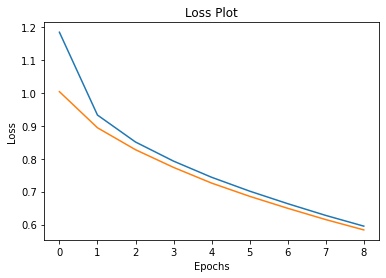

In [46]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [47]:
max_l = 39
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_tokeniser.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(word_tokeniser.index_word[predicted_id])

        if word_tokeniser.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions



### Beam Search(optional)

In [48]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw


def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [word_tokeniser.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_tokeniser.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [word_tokeniser.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption



In [49]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [50]:
from nltk.translate.bleu_score import sentence_bleu

In [51]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [52]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

BLEU score: 10.502100630210073
Real Caption: a woman swimmer in a pool gets splashed by her teammate swimming past
Prediction Caption: a man in a suit and a security guard are standing in front of a glass building


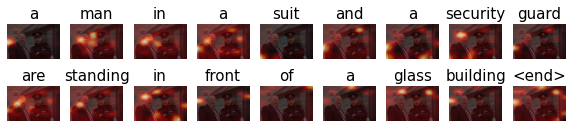

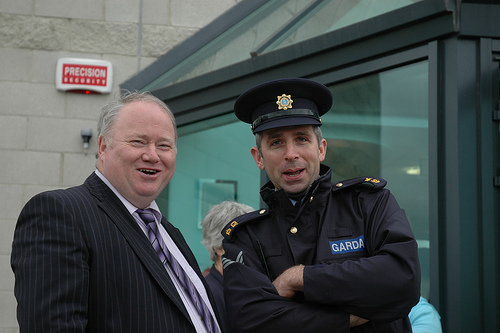

In [53]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([word_tokeniser.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [54]:
captions=beam_evaluate(test_image)
print(captions)

a man in his suit and a man in his suit and a man in his suit and a man in his suit and a man in his suit and a man in his suit and a man


In [55]:
!pip install gTTS

  Using cached gTTS-2.3.1-py3-none-any.whl (28 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [56]:
from gtts import gTTS
from IPython.display import Audio
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)